#####  5E1
2 and 4. they both have multiple predictor variables and multiple slope terms, and therefore are both multiple regressions.

##### 5E2
Animal_diversity ~ Normal(mu,sigma)  
mu = a + beta_latitude * latitude[i] + beta_plant_diversity * plant_diversity[i]  

##### 5E3
time_2_phd ~ Normal (mu,sigma)  
mu = alpha + beta_funding * funding[i] + beta_lab_size * lab_size[i]  
Since both of these variables should be positively associated with mu, both beta should be positive.  

##### 5E4
1, and 3 should be the same, since k-1 dummy variables is enough to model k dummy variables. see page 155  
2 is a non-identifiable model. see top of page 156  
4 is using unique index approach. see page 158  
5 is using the reparameterized approach. see overthinking box on page 154  
So the answer is 1,3,4,5

In [3]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

# Load the data
d = pd.read_csv('../Data/Howell1.csv', sep=';', header=0)
# d = d[d.age >= 18]
d['weight_c'] = d.weight - d.weight.mean()



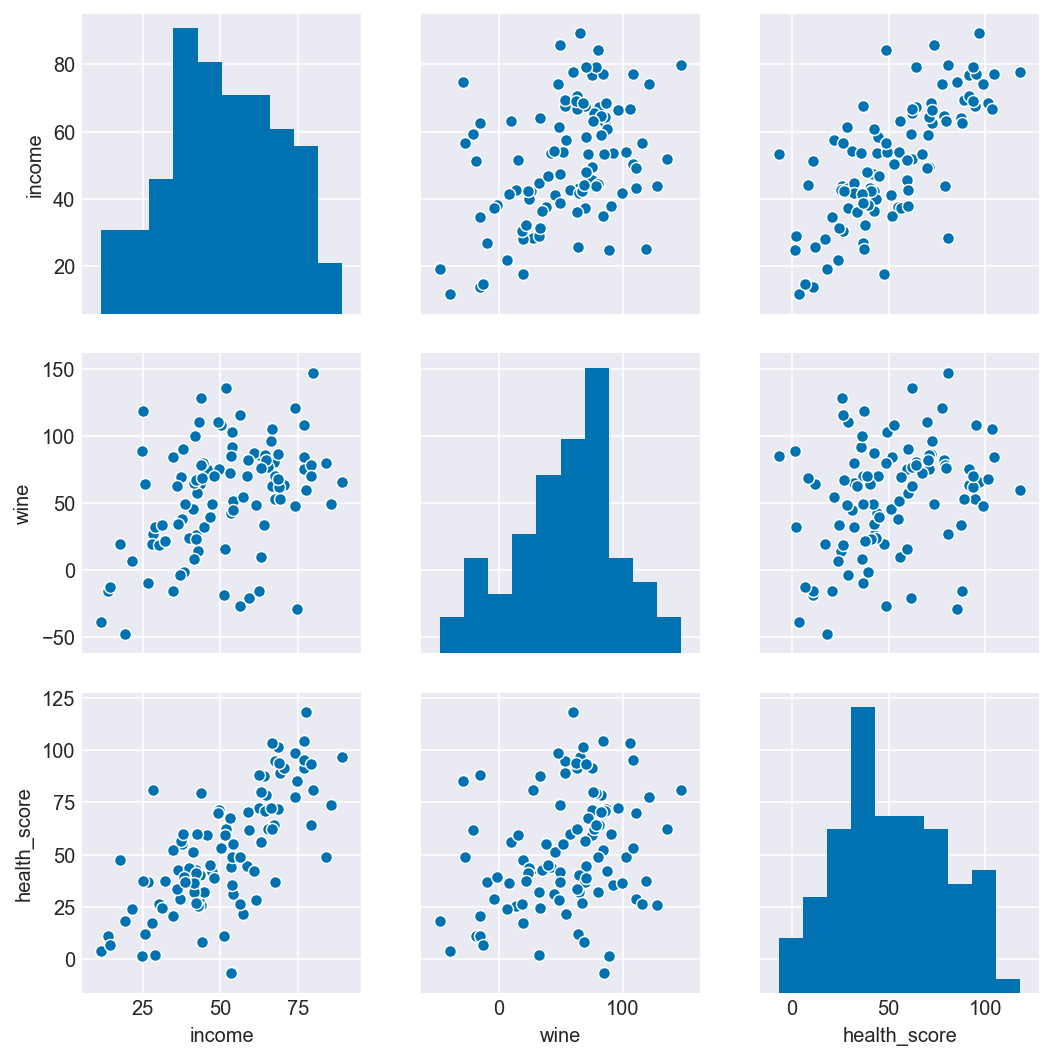

In [4]:
# 5M1
# Let's invent a scenario:
# Study have shown that wine is good for your health
# But actually, after controling for income, wine is a pretty bad predictor for health

n=100
income = np.random.normal(50, 20, size=n)
# liters of wine per day..negative doesn't make sense, but let's pretent they're producing wine
wine= np.random.normal(income, 40, size=n)
# health score 
health_score =np.random.normal(income, 20, size=n)
df= pd.DataFrame({
    'income':income,
    'wine':wine,
    'health_score':health_score,
})
sns.pairplot(df);

In [5]:
# Let's see how we do with just wine
with pm.Model() as m_5m1:
    alpha= pm.Normal('alpha',mu=50,sd=5)
    beta= pm.Normal('beta',mu=0,sd=1)
    mu = pm.Deterministic('mu',alpha + beta * (df.wine-df.wine.mean()))
    sigma=pm.Uniform('sigma',lower=0,upper=50)
    health=pm.Normal('health',mu=mu,sd=sigma,observed =df.health_score)
    trace_5m1=pm.sample(1000,tune=1000)

var=['alpha','beta','sigma']
pm.summary(trace_5m1,alpha=.11,varnames=var).round(2)

# beta is at 0.17

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████████████████████████████████████████████████| 4000/4000 [00:03<00:00, 1079.90draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,51.4,2.40,0.05,47.97,55.61,2427.45,1.0
beta,0.2,0.06,0.00,0.10,0.29,2985.44,1.0
sigma,27.0,1.96,0.04,23.82,29.80,2624.99,1.0


In [6]:
# now let's add in both wine and income as predictor
with pm.Model() as m_5m1_b:
    alpha= pm.Normal('alpha',mu=50,sd=5)
    beta= pm.Normal('beta',mu=0,sd=1,shape=2)
    mu = pm.Deterministic('mu',alpha + beta[0] * (df.wine-df.wine.mean())+ beta[1] * (df.income-df.income.mean()))
    sigma=pm.Uniform('sigma',lower=0,upper=50)
    health=pm.Normal('health',mu=mu,sd=sigma,observed =df.health_score)
    trace_m_5m1_b=pm.sample(1000,tune=1000)

var=['alpha','beta','sigma']
pm.summary(trace_m_5m1_b,alpha=.11,varnames=var).round(2)

# As we can see here. beta_0, the wine predictor, is now almost zero

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 4000/4000 [00:04<00:00, 864.66draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,51.67,1.82,0.03,48.58,54.23,2672.66,1.0
beta__0,0.00,0.05,0.00,-0.08,0.08,1853.40,1.0
beta__1,1.11,0.12,0.00,0.93,1.31,2037.36,1.0
sigma,19.57,1.40,0.03,17.37,21.79,2151.83,1.0


In [36]:
with pm.Model() as m:
    a=pm.Normal('a',mu =170, sd=30, shape=len(d['male'].unique()))
    beta = pm.Normal('beta',mu=1,sd=2)
    sigma = pm.Uniform('sigma', lower= 0 , upper= 50)
    mu = pm.Deterministic('mu', a[d['male'].values] + beta * d.weight_c)
    height =  pm.Normal('height', mu = mu, sd=sigma, observed = d['height'])
    trace_m = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, a]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 4000/4000 [00:06<00:00, 649.95draws/s]


In [34]:
pm.summary(trace_m, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a__0,151.54,0.35,0.01,151.04,152.16,1579.40,1.0
a__1,158.05,0.37,0.01,157.46,158.63,2141.20,1.0
beta,0.64,0.04,0.00,0.57,0.71,1681.98,1.0
sigma,4.28,0.16,0.00,4.01,4.51,1985.36,1.0
mu__0,159.87,0.34,0.01,159.30,160.38,2610.35,1.0
mu__1,146.09,0.38,0.01,145.51,146.71,3636.80,1.0
mu__2,143.13,0.52,0.01,142.33,143.94,3167.23,1.0
mu__3,163.21,0.38,0.01,162.61,163.82,2933.25,1.0
mu__4,149.16,0.32,0.01,148.64,149.63,2261.57,1.0
mu__5,169.58,0.69,0.01,168.42,170.60,2141.28,1.0
